# The Solow Model

By Mathilde Maix & Nina Frandsen Jensen

Imports and set magics:

In [114]:
import numpy as np
from scipy import optimize
import sympy as sm
from matplotlib import pyplot as plt

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Model description

**Solow model** 

Production function:
$$
Y_t = K_t^αH_t^σ(A_tL_t)^{(1-α-σ)}
$$

Y is output, K is physical capital, L is labor, H is human capital and A is technology. α and σ are the output elasticities of physical capital and human capital, respectively, and (1-α-σ) is the output elasticity of labor. 
Savings are divided in physical capital savings and human capital savings. They are defined as a constant fraction of the income. 
$$
S_t=(s_K+s_H)Y_t
$$

The accumulation of physical capital over time is defined as:
$$
K_{t+1} = s_KY_t + (1-δ)K_t
$$
where δ is the depreciation rate of capital, and $K_{t+1}$ and $K_t$ are the levels of physical capital in periods t+1 and t, respectively.

The accumulation of human capital over time is defined as:
$$
H_{t+1} = s_HY_t +(1-δ)H_t
$$
where δ is the depreciation rate of capital and $H_{t+1}$ and $H_t$ are the levels of human capital in periods t+1 and t, respectively.

Finally, the level of technology and labor are defined as:
$$
A_{t+1} = (1+g)A_t
$$
$$
L_{t+1} = (1+n)L_t
$$
where g is the rate of technological progress and n is the population growth. 

We define tilde-variables:
$$
\tilde{y}_{t}= \frac{Y_t}{A_tL_t}
$$
$$
\tilde{k}_{t}= \frac{K_t}{A_tL_t}
$$
$$
\tilde{h}_{t}= \frac{H_t}{A_tL_t}
$$
We define the transitions equation for physical capital and human capital as

$$
\begin{aligned}

    \tilde{k}_{t+1} &= \frac{1}{(1+n)(1+g)}(s_K \tilde{k}_t^{\alpha} \tilde{h}_t^{σ} + (1-\delta) \tilde{k}_t),\\
    
    \tilde{h}_{t+1} &= \frac{1}{(1+n)(1+g)}(s_H \tilde{h}_t^{\alpha} \tilde{h}_t^{σ} + (1-\delta) \tilde{h}_t).\\

\end{aligned}
$$


## Analytical solution

We begin by trying to solve the general Solow model analytically, and will expand with human capital later in the project. 

In [115]:
# Define the variables and parameters
k, L, s, delta, alpha, n, g = sm.symbols('k L s delta alpha n g')

# Define the production function
Y = k**alpha * L**(1-alpha)

# Define the savings and accumulation equations
S = s*Y
K_next = S + (1-delta)*k

# Define the labor accumulation equation
L_next = (1+n)*L

# Define the system of equations and solve for the steady state values
system = [Y - delta*k - K_next,
          S - K_next,
          L_next - L]

ss_sol = sm.solve(system, [k, L])

# Define the steady state function
k_ss = sm.lambdify((s, delta, alpha, n, g), ss_sol[0])

# Test the function with example parameters
params = (0.6, 0.05, 0.3, 0.01, 0.025)
print(k_ss(*params))

(0, 0)


Simpy solve on the Solow model was unsuccessful. This is because in the Solow model, the steady state values of k, L, and A are normally found by solving a system of nonlinear equations numerically, rather than analytically.

## Numerical solution

Now we solve the model numerically. We have included human capital, and begin by defining the variables, parameters and the transition equations.  

In [116]:
# Define symbols 
k_tilde, h_tilde = sm.symbols('ktilde_t, htilde_t')
sK, sH = sm.symbols('s_K, s_H')
g, n  = sm.symbols('g, n')
delta, alpha, phi = sm.symbols('delta, alpha, phi')

# Define transistion equations
trans_k = sm.Eq(k_tilde, 
                1/((1+n)*(1+g))*(sK*k_tilde**alpha*h_tilde**phi+(1-delta)*k_tilde))
trans_h = sm.Eq(h_tilde, 
                1/((1+n)*(1+g))*(sH*k_tilde**alpha*h_tilde**phi+(1-delta)*h_tilde))

# Derive nullclines from transition equations, isolate for h tilde 
no_change_k = sm.solve(trans_k,h_tilde)[0] 
null_k = sm.Eq(h_tilde, no_change_k)

no_change_h = sm.solve(trans_h,h_tilde)[0]
null_h = sm.Eq(h_tilde, no_change_h)

# Display nullclines 
display(null_k)
display(null_h)


Eq(htilde_t, (ktilde_t**(1 - alpha)*(delta + g*n + g + n)/s_K)**(1/phi))

Eq(htilde_t, ((delta + g*n + g + n)/(ktilde_t**alpha*s_H))**(1/(phi - 1)))

From the power of $\tilde{k}$, we observe that the nullcline for $\triangle\tilde{k} = 0$ is convex, while the nullcline for $\triangle\tilde{h} = 0$ is concave in the $\tilde{k}$ dimension. We know wish to show the nullclines in a fase diagram

In [117]:
# a. lambdify nullclines 
null_k_func = sm.lambdify([k_tilde, alpha, delta, g, n, phi, sK], no_change_k)
null_h_func = sm.lambdify([k_tilde, alpha, delta, g, n, phi, sH], no_change_h)

# b. generate values 
# i. define independent values in nullcline
k_tilde_vec = np.linspace(1e-10,3,100)

# ii. use standard parameter-values from model
par = model.par 

alpha_val = par.alpha
delta_val = par.delta
g_val = par.g
n_val = par.n
phi_val = par.phi
sK_val = 0.12
sH_val = 0.07

# ii. insert in lamdified nullclines
null_k_val = null_k_func(k_tilde_vec,alpha_val,delta_val,g_val, n_val, phi_val, sK_val)
null_h_val = null_h_func(k_tilde_vec,alpha_val,delta_val,g_val, n_val, phi_val, sH_val)

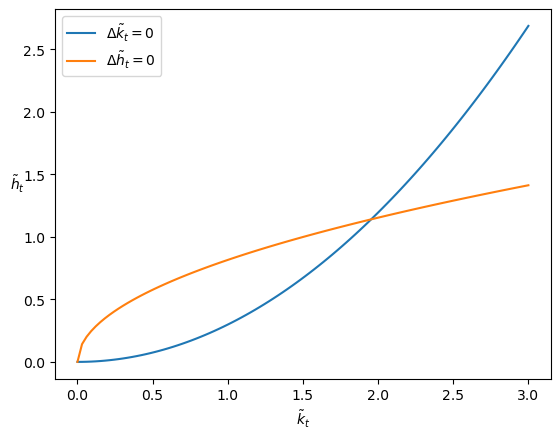

In [118]:
# Plot
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.plot(k_tilde_vec, null_k_val, label = r'$ \Delta \tilde{k}_t = 0$')
ax.plot(k_tilde_vec, null_h_val, label = r'$ \Delta \tilde{h}_t = 0$');
ax.set_xlabel(r'$\tilde{k}_t$',)
ax.set_ylabel(r'$\tilde{h}_t$', rotation = 0)

ax.legend(loc='upper left');

The fase diagram shows the transition to steady state. The steady state is where the null clines intersect each other. 
Now we will find the steady state and graph the convergence. 

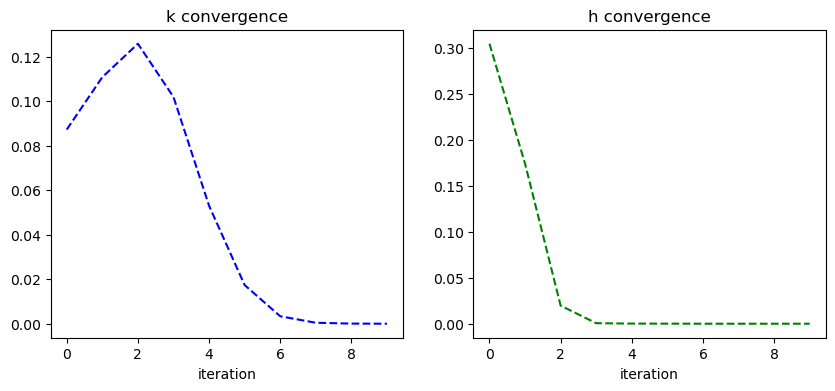

In [119]:

def steady_state(sK, sH, delta, g, n, alpha, sigma, evals=10):
    k, h = 0.5, 0.5
    fks = np.zeros(evals)
    fhs = np.zeros(evals)
    for i in range(evals):
        k_new = ((sK*h**sigma) + (1-delta)*k)**(1/(1-alpha))
        h_new = ((sH*k**alpha) + (1-g)*h)**(1/sigma)
        fks[i] = np.abs(k_new - k)
        fhs[i] = np.abs(h_new - h)
        k, h = k_new, h_new
        
    # Plot the convergences for k and h
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    i = evals-1
    axs[0].plot(np.arange(i+1), fks[:i+1], '--', ms=4, color='blue')
    axs[0].set_title("k convergence")
    axs[0].set_xlabel('iteration')
    axs[1].plot(np.arange(i+1), fhs[:i+1], '--', ms=4, color='green')
    axs[1].set_title("h convergence")
    axs[1].set_xlabel('iteration')
    plt.show()
    
    # Return the steady state values of physical and human capital
    return k, h

# Find the steady state values of physical and human capital
ss_k, ss_h = steady_state(0.1, 0.11, 0.05, 0.015, 0.01, 1/3, 1/3)


# Extension of the model

In this part of the analysis, we analyse how the steady state values change when increasing the savings rate.

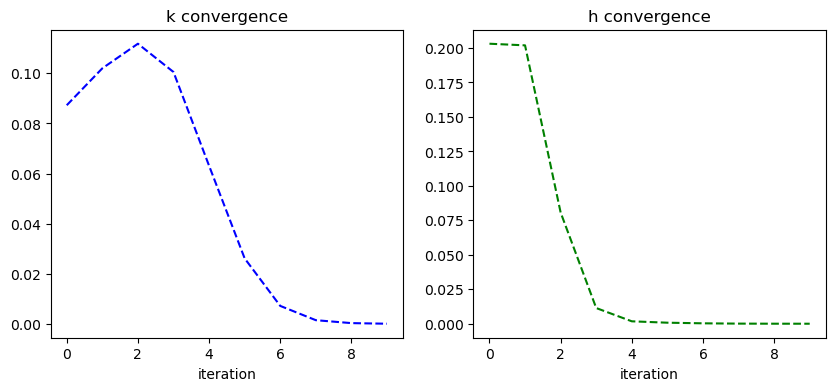

In [120]:
ss_k1, ss_h1 = steady_state(0.1, 0.22, 0.05, 0.015, 0.01, 1/3, 1/3)

TypeError: 'numpy.ndarray' object is not callable

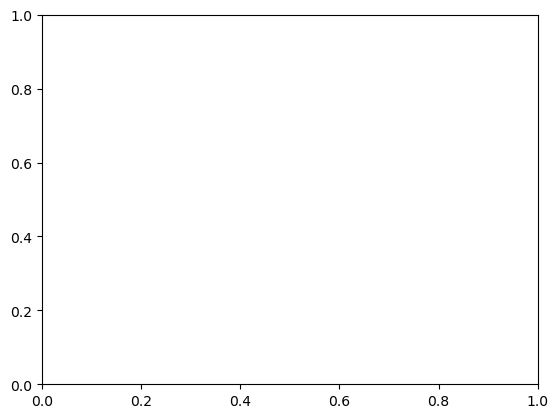

In [121]:
# Plot
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.plot(k_tilde_vec, null_k_val(k_tilde_vec, alpha, phi, delta, g, n, sK), color='black')
ax.plot(k_tilde_vec, null_h_val(k_tilde_vec, alpha, phi, delta, g, n, sH), color='black')
ax.plot(k_tilde_vec, null_h_val(k_tilde_vec, alpha, phi, delta, g, n, 0.11), color='red') # increase in sH
ax.set_xlabel(r'$\tilde{k}_t$',)
ax.set_ylabel(r'$\tilde{h}_t$', rotation = 0)

ax.legend(loc='upper left');

We see that an increase in human capital savings rate leads to an initial increase in the savings in human capital. Production per effective worker increases also increases , which leads to higher savings in both human and physical capital.

# Conclusion

We can conclude that it was not possible to solve the Solow model analytically. 